Granger因果关系分析
使用分号作为分隔符成功加载数据
数据形状: (12936, 16)
使用以下列进行分析:
  - 日期列: Date
  - 情感列: Compound_Score
  - 价格列: Close
转换日期列 'Date' 为日期时间类型...

数据准备完成，开始进行Granger因果检验...

1. 检验价格是否Granger导致情感:
        F统计量        p值  拒绝零假设
1   3.928475  0.047497   True
2   2.826561  0.059255  False
3   2.951267  0.031339   True
4   3.045178  0.016092   True
5   3.138523  0.007805   True
6   2.888169  0.008178   True
7   2.747142  0.007529   True
8   2.666689  0.006344   True
9   2.527586  0.006823   True
10  2.429622  0.006891   True

2. 检验情感是否Granger导致价格:
        F统计量        p值  拒绝零假设
1   0.335636   0.56237  False
2   0.206895  0.813108  False
3   0.611743  0.607312  False
4   0.480017  0.750456  False
5   0.382802  0.860899  False
6   0.416009  0.868892  False
7   0.742102   0.63622  False
8   0.640171  0.744509  False
9   0.567231  0.825019  False
10  0.495246  0.894291  False


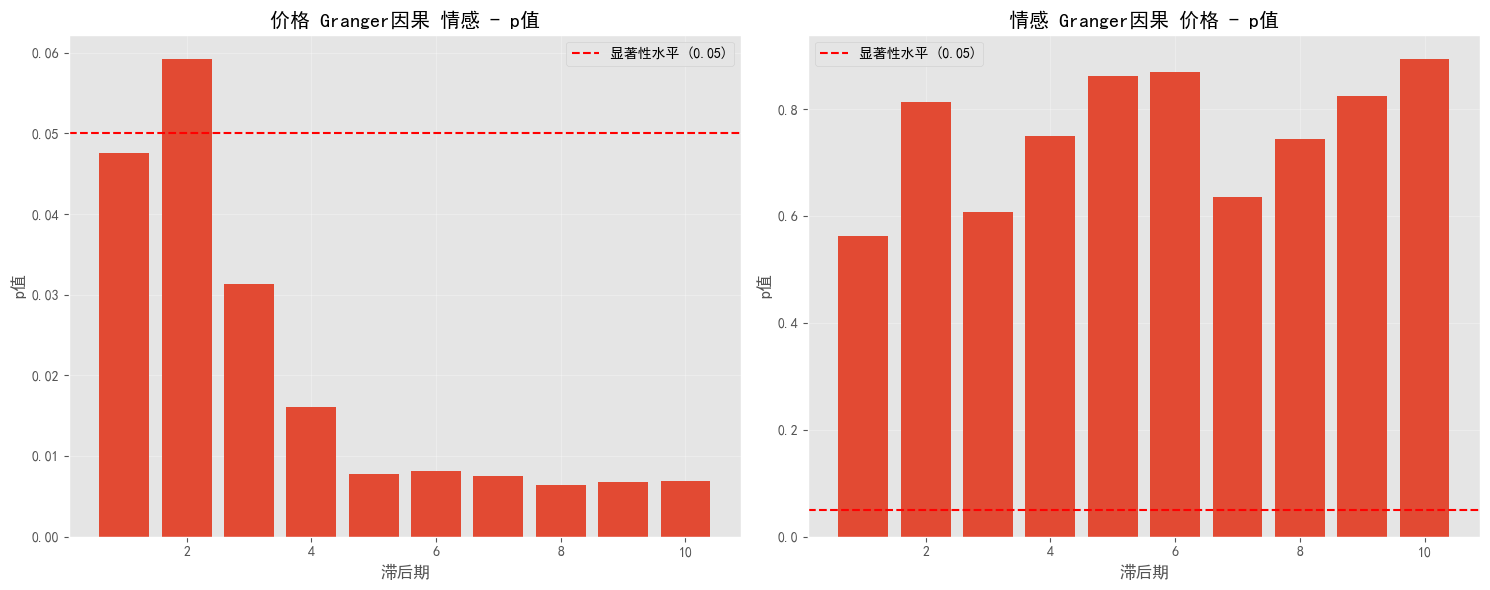


因果关系检验总结:
- 价格确实在统计上Granger导致情感 (在滞后期 [1, 3, 4, 5, 6, 7, 8, 9, 10] 显著)
- 未发现情感对价格的显著Granger因果关系


In [2]:
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import grangercausalitytests
import warnings
warnings.filterwarnings('ignore')

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('ggplot')

def granger_causality_analysis(filepath, maxlag=10):
    """
    使用Granger因果检验分析价格和情感之间的因果关系
    
    参数:
    filepath: 数据文件路径
    maxlag: 最大滞后期数
    """
    print("="*80)
    print("Granger因果关系分析")
    print("="*80)
    
    # 加载数据
    try:
        # 尝试不同的分隔符
        try:
            df = pd.read_csv(filepath, sep=';', encoding='utf-8')
            print(f"使用分号作为分隔符成功加载数据")
        except:
            df = pd.read_csv(filepath, encoding='utf-8')
            print(f"使用默认分隔符成功加载数据")
        
        print(f"数据形状: {df.shape}")
    except Exception as e:
        print(f"加载数据失败: {e}")
        return None
    
    # 查找关键列
    date_cols = [col for col in df.columns if any(term in col.lower() for term in ['date', 'time'])]
    sentiment_cols = [col for col in df.columns if any(term in col.lower() for term in 
                     ['sentiment', 'compound', 'score', 'positive', 'negative'])]
    price_cols = [col for col in df.columns if any(term in col.lower() for term in 
                 ['price', 'close', 'open', 'high', 'low'])]
    
    # 验证找到了必要的列
    if not (date_cols and sentiment_cols and price_cols):
        print("缺少必要的列（日期、情感或价格）。请检查数据结构。")
        print("可用列: ", df.columns.tolist())
        return None
    
    # 选择要使用的主要列
    date_col = date_cols[0]
    sentiment_col = [col for col in sentiment_cols if 'compound' in col.lower() or 'score' in col.lower()]
    sentiment_col = sentiment_col[0] if sentiment_col else sentiment_cols[0]
    price_col = [col for col in price_cols if 'close' in col.lower()]
    price_col = price_col[0] if price_col else price_cols[0]
    
    print(f"使用以下列进行分析:")
    print(f"  - 日期列: {date_col}")
    print(f"  - 情感列: {sentiment_col}")
    print(f"  - 价格列: {price_col}")
    
    # 确保日期列是日期时间类型
    if df[date_col].dtype != 'datetime64[ns]':
        print(f"转换日期列 '{date_col}' 为日期时间类型...")
        try:
            df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
        except Exception as e:
            print(f"日期转换失败: {e}")
            return None
    
    # 按日期排序
    df = df.sort_values(by=date_col)
    
    # 设置日期为索引
    df.set_index(date_col, inplace=True)
    
    # 准备用于Granger因果检验的数据
    # 确保数据是平稳的 - 使用差分
    price_diff = df[price_col].diff().dropna()
    sentiment_diff = df[sentiment_col].diff().dropna()
    
    # 确保两个序列长度匹配
    min_length = min(len(price_diff), len(sentiment_diff))
    price_diff = price_diff[-min_length:]
    sentiment_diff = sentiment_diff[-min_length:]
    
    # 创建用于检验的数据框
    data_for_test = pd.DataFrame({
        'price': price_diff,
        'sentiment': sentiment_diff
    })
    
    # 移除任何NaN值
    data_for_test = data_for_test.dropna()
    
    print("\n数据准备完成，开始进行Granger因果检验...")
    
    # 执行Granger因果检验 - 价格对情感的影响
    print("\n1. 检验价格是否Granger导致情感:")
    gc_result_price_to_sentiment = grangercausalitytests(
        data_for_test[['sentiment', 'price']], maxlag=maxlag, verbose=False)
    
    # 提取并显示结果
    price_to_sentiment_results = pd.DataFrame(
        index=range(1, maxlag+1),
        columns=['F统计量', 'p值', '拒绝零假设']
    )
    
    for lag in range(1, maxlag+1):
        # Wald检验的F统计量和p值
        f_stat = gc_result_price_to_sentiment[lag][0]['ssr_ftest'][0]
        p_value = gc_result_price_to_sentiment[lag][0]['ssr_ftest'][1]
        reject = p_value < 0.05
        
        price_to_sentiment_results.loc[lag] = [f_stat, p_value, reject]
    
    print(price_to_sentiment_results)
    
    # 执行Granger因果检验 - 情感对价格的影响
    print("\n2. 检验情感是否Granger导致价格:")
    gc_result_sentiment_to_price = grangercausalitytests(
        data_for_test[['price', 'sentiment']], maxlag=maxlag, verbose=False)
    
    # 提取并显示结果
    sentiment_to_price_results = pd.DataFrame(
        index=range(1, maxlag+1),
        columns=['F统计量', 'p值', '拒绝零假设']
    )
    
    for lag in range(1, maxlag+1):
        # Wald检验的F统计量和p值
        f_stat = gc_result_sentiment_to_price[lag][0]['ssr_ftest'][0]
        p_value = gc_result_sentiment_to_price[lag][0]['ssr_ftest'][1]
        reject = p_value < 0.05
        
        sentiment_to_price_results.loc[lag] = [f_stat, p_value, reject]
    
    print(sentiment_to_price_results)
    
    # 可视化结果
    plt.figure(figsize=(15, 6))
    
    # 价格到情感的p值
    plt.subplot(1, 2, 1)
    plt.bar(price_to_sentiment_results.index, price_to_sentiment_results['p值'])
    plt.axhline(y=0.05, color='r', linestyle='--', label='显著性水平 (0.05)')
    plt.title('价格 Granger因果 情感 - p值')
    plt.xlabel('滞后期')
    plt.ylabel('p值')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 情感到价格的p值
    plt.subplot(1, 2, 2)
    plt.bar(sentiment_to_price_results.index, sentiment_to_price_results['p值'])
    plt.axhline(y=0.05, color='r', linestyle='--', label='显著性水平 (0.05)')
    plt.title('情感 Granger因果 价格 - p值')
    plt.xlabel('滞后期')
    plt.ylabel('p值')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 总结结果
    price_to_sentiment_significant = price_to_sentiment_results['拒绝零假设'].any()
    sentiment_to_price_significant = sentiment_to_price_results['拒绝零假设'].any()
    
    print("\n因果关系检验总结:")
    if price_to_sentiment_significant:
        significant_lags = price_to_sentiment_results[price_to_sentiment_results['拒绝零假设']].index.tolist()
        print(f"- 价格确实在统计上Granger导致情感 (在滞后期 {significant_lags} 显著)")
    else:
        print("- 未发现价格对情感的显著Granger因果关系")
        
    if sentiment_to_price_significant:
        significant_lags = sentiment_to_price_results[sentiment_to_price_results['拒绝零假设']].index.tolist()
        print(f"- 情感确实在统计上Granger导致价格 (在滞后期 {significant_lags} 显著)")
    else:
        print("- 未发现情感对价格的显著Granger因果关系")
    
    return {
        'data': data_for_test,
        'price_to_sentiment': price_to_sentiment_results,
        'sentiment_to_price': sentiment_to_price_results
    }

# 调用函数进行Granger因果检验
granger_results = granger_causality_analysis('../dataset/df_Final.csv')